## POS tagging using modified Viterbi

Apply techniques to improve Vanilla Viterbi Algorithm performance by handling unknown words in the corpus

Approach:

1. Develop plain vanilla Viterbi Algorithm.
2. Viterbi Modification-Technique I
    - Transition probability is considered in case of unknown words.
3. Viterbi Modification-Technique II
    - Use Rule based tagger in case of unknown words.
3. The modified Viterbi algorithms tested on sample validation data and compared.
4. The final algorithms are tested on full test data.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#nltk.download('universal_tagset')

In [3]:
from nltk.corpus import treebank

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# let's check some of the tagged data
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
# Splitting into train and test(validation)
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))

3718
196


In [7]:

# Getting list of tagged train words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95622

In [8]:
train_tagged_words[:5]

[('Vicar', 'NOUN'),
 ('Marshall', 'NOUN'),
 ('admits', 'VERB'),
 ('to', 'PRT'),
 ('mixed', 'VERB')]

In [9]:
# Get the tokens/words from tagged word, POS pair 
tokens = [pair[0] for pair in train_tagged_words]
print(len(tokens))
tokens[:5]

95622


['Vicar', 'Marshall', 'admits', 'to', 'mixed']

In [10]:
# Create the vocabulary of tokens
V = set(tokens)
print(len(V))
N_Words=int(len(V))

12110


In [11]:
# Get all the unique tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'PRT', 'NUM', '.', 'ADJ', 'PRON', 'NOUN', 'ADP', 'VERB', 'X', 'DET', 'ADV', 'CONJ'}


There are only 12 tags in the corpus for simplicity

##### Computing Probabilities

We'll use the HMM algorithm to tag the words. For every word w, assign the tag t that maximises the likelihood P(t/w).

P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

Now:

P(w/t): is the emission probability of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: P(w/t) = count(w, t) / count(t).

P(t): is the probability of tag (also transition probability), and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

In [12]:

# computing P(w/t) and creating a T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# most frequent tag in the corpus
tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)

# the most common tags can using the most_common() method of Counter
most_common_tags = tag_counts.most_common(5)
print(most_common_tags)

[('NOUN', 27438), ('VERB', 12857), ('.', 11129), ('ADP', 9374), ('DET', 8251)]


In [14]:
# Getting the list of tagged test words

# Running Viterbi algorithm on the entire test dataset would take a lot of time. 
# We'll test it on a few sample sentences of validation dataset

random.seed(1234)

# select 10 random sentences
random_sents = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in random_sents]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
len(test_tagged_words)

304

### Emission Probabilities

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [16]:
# testing the Emission Probability function
print("\n", "service")
print(word_given_tag('service', 'CONJ'))
print(word_given_tag('service', 'NOUN'))
print(word_given_tag('service', 'ADJ'))
print(word_given_tag('service', 'ADV'))
print(word_given_tag('service', 'VERB'), "\n")
print("\n", "post")
print(word_given_tag('post', 'CONJ'))
print(word_given_tag('post', 'NOUN'))
print(word_given_tag('post', 'ADJ'))
print(word_given_tag('post', 'ADV'))
print(word_given_tag('post', 'VERB'), "\n")



 service
(0, 2151)
(24, 27438)
(0, 6089)
(0, 3006)
(0, 12857) 


 post
(0, 2151)
(4, 27438)
(0, 6089)
(0, 3006)
(2, 12857) 



### Transition Probabilities

In [17]:
# compute tag t2 given tag t1
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for i in range(len(tags)-1):
        if tags[i] == t1 and tags[i+1] == t2:
            count_t2_t1 += 1
    return(count_t2_t1, count_t1)

In [18]:
#test Transition probability
print(t2_given_t1(t2='DET', t1='NOUN'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('CONJ', 'VERB'))
print(t2_given_t1('X', 'PRON'))

(364, 27438)
(4023, 27438)
(71, 12857)
(244, 2599)


In [19]:
# Note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('PRON', '.'))

(1918, 11129)
(2494, 11129)
(990, 11129)
(726, 11129)


##### Matrix of Transition Probabilities

In [20]:
print(T)

{'PRT', 'NUM', '.', 'ADJ', 'PRON', 'NOUN', 'ADP', 'VERB', 'X', 'DET', 'ADV', 'CONJ'}


In [21]:
#from __future__ import division

In [22]:
# t1 x t2 matrix of transition probablities of tags

tags_matrix = np.zeros((len(T), len(T)), dtype = 'float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        #tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        #print(t2_given_t1(t2, t1)[0] , t2_given_t1(t2, t1)[1])
        count_t2_t1, count_t1 = t2_given_t1(t2, t1)
        tags_matrix[i,j] = count_t2_t1 / count_t1

In [23]:
tags_matrix

array([[1.96721312e-03, 5.86885251e-02, 4.13114764e-02, 8.39344263e-02,
        1.86885241e-02, 2.48196721e-01, 2.06557382e-02, 3.99672121e-01,
        1.34426225e-02, 1.01967216e-01, 9.83606558e-03, 1.63934426e-03],
       [2.77367961e-02, 1.85305402e-01, 1.18619062e-01, 3.33431698e-02,
        1.47536141e-03, 3.52611393e-01, 3.51136029e-02, 1.77043378e-02,
        2.08616108e-01, 2.95072282e-03, 2.95072282e-03, 1.35733252e-02],
       [2.42609391e-03, 8.14089328e-02, 9.19220075e-02, 4.37595472e-02,
        6.52349740e-02, 2.24099204e-01, 9.15625840e-02, 8.89567807e-02,
        2.79450081e-02, 1.72342524e-01, 5.28349355e-02, 5.74175566e-02],
       [1.10034486e-02, 2.10215151e-02, 6.50353059e-02, 6.76629990e-02,
        6.56922348e-04, 6.97979987e-01, 7.70241395e-02, 1.19888326e-02,
        2.05288231e-02, 4.76268679e-03, 4.92691761e-03, 1.74084418e-02],
       [1.30819548e-02, 6.15621405e-03, 4.15544435e-02, 7.34898001e-02,
        7.69526744e-03, 2.10850328e-01, 2.30858028e-02, 4.81

In [24]:
# convert matrix into dataframe for better visuals
tags_df = pd.DataFrame(tags_matrix, columns=list(T), index=list(T))
tags_df

,PRT,NUM,.,ADJ,PRON,NOUN,ADP,VERB,X,DET,ADV,CONJ
PRT,0.001967,0.058689,0.041311,0.083934,0.018689,0.248197,0.020656,0.399672,0.013443,0.101967,0.009836,0.001639
NUM,0.027737,0.185305,0.118619,0.033343,0.001475,0.352611,0.035114,0.017704,0.208616,0.002951,0.002951,0.013573
.,0.002426,0.081409,0.091922,0.043760,0.065235,0.224099,0.091563,0.088957,0.027945,0.172343,0.052835,0.057418
ADJ,0.011003,0.021022,0.065035,0.067663,0.000657,0.697980,0.077024,0.011989,0.020529,0.004763,0.004927,0.017408
PRON,0.013082,0.006156,0.041554,0.073490,0.007695,0.210850,0.023086,0.481339,0.093882,0.009619,0.033859,0.005387
NOUN,0.043371,0.009695,0.240287,0.012173,0.004629,0.264269,0.177127,0.146621,0.029011,0.013266,0.016911,0.042642
ADP,0.001280,0.061980,0.039898,0.107531,0.068594,0.322594,0.017282,0.008214,0.034777,0.323128,0.013761,0.000960
VERB,0.031656,0.023178,0.035000,0.064867,0.036012,0.111068,0.091312,0.168624,0.217936,0.133624,0.081201,0.005522
X,0.184131,0.002703,0.162347,0.017332,0.055494,0.062331,0.144220,0.206233,0.074734,0.054063,0.026236,0.010176
DET,0.000242,0.022422,0.018058,0.205430,0.003757,0.636165,0.009090,0.040480,0.045813,0.005454,0.012605,0.000485


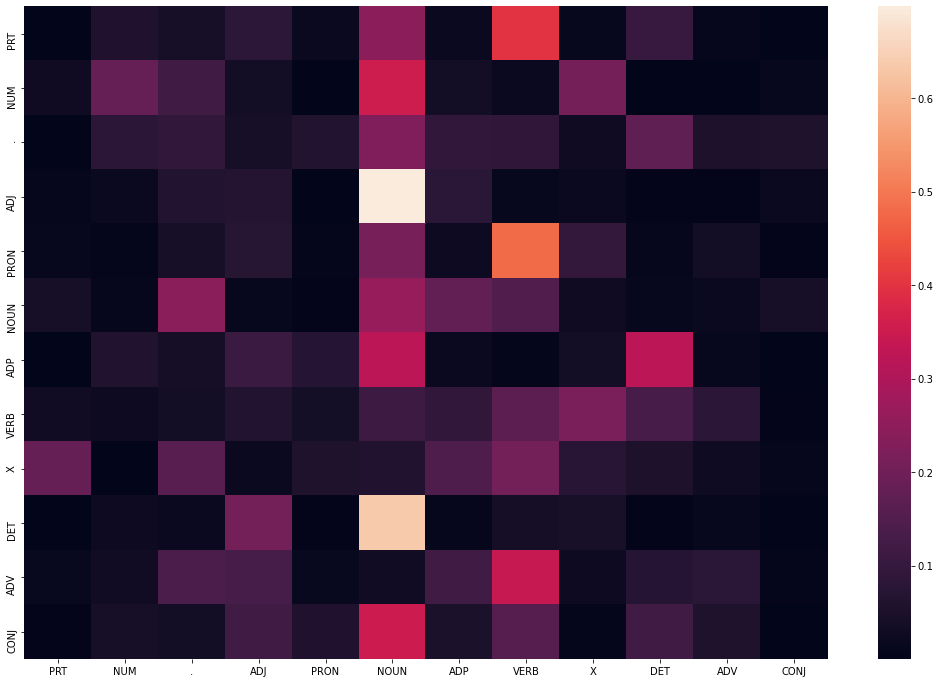

In [25]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

Heat map shows high Transition probability of DET->NOUN and ADJ->NOUN which is expected as well

### Build the vanilla Viterbi based POS tagger

For each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

In [26]:
len(train_tagged_words)

95622

In [27]:
# viterbi heuristic
def Viterbi(words, train_bag=train_tagged_words):
    state=[]
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # initialise Probability for the given word
        p = []
        for tag in T:
            if key==0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p - tags_df.loc[state[-1], tag]
            
            #compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            #if emission_p == 0:
            #    emission_p = 0.000001
                
            state_prob = emission_p * transition_p
            p.append(state_prob)
            
        p_max = max(p)
        #state for which probability is maximum
        state_max = T[p.index(p_max)]
        state.append(state_max)
    
    return(list(zip(words, state)))

### Evaluating on Validation Set

In [28]:
# tag the test sentences for validation using vanilla viterbi heuristic
start = time.time()
test_tagged_seq = Viterbi(test_tagged_words)
end = time.time()
diff = end - start
print('Test tagged sequence:', test_tagged_seq)
print('Time taken: ', diff)

Test tagged sequence: [('``', '.'), ('Nasty', 'PRT'), ('innuendoes', 'PRT'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*-2', 'X'), ('John', 'NOUN'), ('Siegal', 'PRT'), (',', '.'), ('Mr.', 'NOUN'), ('Dinkins', 'NOUN'), ("'s", 'PRT'), ('issues', 'NOUN'), ('director', 'NOUN'), (',', '.'), ('``', '.'), ('designed', 'VERB'), ('*', 'X'), ('*-1', 'X'), ('to', 'PRT'), ('prosecute', 'PRT'), ('a', 'DET'), ('case', 'NOUN'), ('of', 'ADP'), ('political', 'ADJ'), ('corruption', 'NOUN'), ('that', 'ADP'), ('*T*-74', 'X'), ('simply', 'ADV'), ('does', 'VERB'), ("n't", 'ADV'), ('exist', 'VERB'), ('.', '.'), ("''", '.'), ('Giant', 'NOUN'), ('Group', 'NOUN'), ('is', 'VERB'), ('led', 'VERB'), ('*-96', 'PRT'), ('by', 'ADP'), ('three', 'NUM'), ('Rally', 'NOUN'), ("'s", 'PRT'), ('directors', 'NOUN'), (',', '.'), ('Burt', 'NOUN'), ('Sugarman', 'NOUN'), (',', '.'), ('James', 'NOUN'), ('M.', 'NOUN'), ('Trotter', 'NOUN'), ('III', 'NOUN'), ('and', 'CONJ'), ('William', 'NOUN'), ('E.', 'NOUN'), ('Trotter', 'NOUN')

In [29]:
# check accuracy on validation
check = [i for i, j in zip(test_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(test_tagged_seq)
print('Vanilla Viterbi Accuracy: ', accuracy)

Vanilla Viterbi Accuracy:  0.9111842105263158


In [30]:
# incorrect tags
#incorrect_tags = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tags = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_tagged_seq, test_run_base)) if j[0]!=j[1]]
print(incorrect_tags)
print('No. of incorrect tags: ', len(incorrect_tags))

[[('``', '.'), (('Nasty', 'PRT'), ('Nasty', 'ADJ'))], [('Nasty', 'ADJ'), (('innuendoes', 'PRT'), ('innuendoes', 'NOUN'))], [('John', 'NOUN'), (('Siegal', 'PRT'), ('Siegal', 'NOUN'))], [('to', 'PRT'), (('prosecute', 'PRT'), ('prosecute', 'VERB'))], [('corruption', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('led', 'VERB'), (('*-96', 'PRT'), ('*-96', 'X'))], [('and', 'CONJ'), (('plan', 'NOUN'), ('plan', 'VERB'))], [('.', '.'), (('Discos', 'PRT'), ('Discos', 'NOUN'))], [('are', 'VERB'), (('exempt', 'PRT'), ('exempt', 'ADJ'))], [('permitted', 'VERB'), (('*-60', 'PRT'), ('*-60', 'X'))], [('in', 'ADP'), (('bars', 'PRT'), ('bars', 'NOUN'))], [('will', 'VERB'), (('rule', 'NOUN'), ('rule', 'VERB'))], [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))], [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('that', 'DET'), (('*T*-179', 'PRT'), ('*T*-179', 'X'))], [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))], [('to', 'PRT'), (('arrive', 'PRT'), ('

### Solve the problem of unknown words

#### Technique 1

##### Modified viterbi 1 : check if word is in corpus, if not assign only transition probability

In [31]:
#Modifying the vannila viterbi
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    
    #get the list of tags
    T = list(set([pair[1] for pair in train_bag]))
    
    #get all tokens in corpus
    V=[i[0] for i in train_bag]
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
     
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            #if emission_p == 0:
            #    emission_p = 0.000001
            if words[key] in V:
                state_probability = emission_p * transition_p
            else:
                state_probability = transition_p #Considering only the transition prob as emission will be zero        
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        
        state.append(state_max)      
    return list(zip(words, state))

In [32]:
# tagging the test sentences
start = time.time()
tagged_seq_unk = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start
print("tagged_seq: ", tagged_seq_unk )
print("Time taken in seconds: ", difference)

tagged_seq:  [('``', '.'), ('Nasty', 'NOUN'), ('innuendoes', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*-2', 'X'), ('John', 'NOUN'), ('Siegal', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Dinkins', 'NOUN'), ("'s", 'PRT'), ('issues', 'NOUN'), ('director', 'NOUN'), (',', '.'), ('``', '.'), ('designed', 'VERB'), ('*', 'X'), ('*-1', 'X'), ('to', 'PRT'), ('prosecute', 'VERB'), ('a', 'DET'), ('case', 'NOUN'), ('of', 'ADP'), ('political', 'ADJ'), ('corruption', 'NOUN'), ('that', 'ADP'), ('*T*-74', 'X'), ('simply', 'ADV'), ('does', 'VERB'), ("n't", 'ADV'), ('exist', 'VERB'), ('.', '.'), ("''", '.'), ('Giant', 'NOUN'), ('Group', 'NOUN'), ('is', 'VERB'), ('led', 'VERB'), ('*-96', 'X'), ('by', 'ADP'), ('three', 'NUM'), ('Rally', 'NOUN'), ("'s", 'PRT'), ('directors', 'NOUN'), (',', '.'), ('Burt', 'NOUN'), ('Sugarman', 'NOUN'), (',', '.'), ('James', 'NOUN'), ('M.', 'NOUN'), ('Trotter', 'NOUN'), ('III', 'NOUN'), ('and', 'CONJ'), ('William', 'NOUN'), ('E.', 'NOUN'), ('Trotter', 'NOUN'), ('II'

##### Evaluating accuracy for modified viterbi technique 1

In [33]:
# accuracy
check_unk = [i for i, j in zip(tagged_seq_unk, test_run_base) if i == j]
accuracy_unk = len(check_unk)/len(tagged_seq_unk)
print('Accuracy with modified Viterbi 1: ', accuracy_unk)

Accuracy with modified Viterbi 1:  0.9407894736842105


In [34]:
# incorrect tags
incorrect_tagged_cases_unk = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_unk, test_run_base)) if j[0]!=j[1]]
print(incorrect_tagged_cases_unk)
print(len(incorrect_tagged_cases_unk))

[[('``', '.'), (('Nasty', 'NOUN'), ('Nasty', 'ADJ'))], [('corruption', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('and', 'CONJ'), (('plan', 'NOUN'), ('plan', 'VERB'))], [('are', 'VERB'), (('exempt', 'X'), ('exempt', 'ADJ'))], [('in', 'ADP'), (('bars', 'DET'), ('bars', 'NOUN'))], [('will', 'VERB'), (('rule', 'NOUN'), ('rule', 'VERB'))], [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))], [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('that', 'DET'), (('*T*-179', 'DET'), ('*T*-179', 'X'))], [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))], [('prices', 'NOUN'), (('firmed', 'NOUN'), ('firmed', 'VERB'))], [('``', '.'), (('Professional', 'NOUN'), ('Professional', 'ADJ'))], [('get', 'VERB'), (('enough', 'ADV'), ('enough', 'ADJ'))], [('to', 'PRT'), (('attack', 'NOUN'), ('attack', 'VERB'))], [('attack', 'VERB'), (('first', 'ADJ'), ('first', 'ADV'))], [(',', '.'), (('last', 'ADJ'), ('last', 'ADV'))], [('Charities', 'NOUN'), (('test', 'NOUN'

#### Technique 2

##### Modified viterbi  2: rule based assignment using morphological features 

In [35]:
## Modifying using RegEx
def Viterbi_2(incorrect_tagged_cases, tagged_seq_to_improve):
    patterns = [
    (r'.*es$', 'VERB'),
    (r'.*ing$', 'VERB'),
    (r'\d?[a-z]?-[a-z]', 'ADP'),         
    (r'.*ed$', 'VERB'),
    (r'^an?$|the$', 'DET'),              
    (r'.*ful$', 'ADJ'), 
    (r'.*ous$', 'ADJ'),
    (r'.*ble$', 'ADJ'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'.*', 'NOUN')
    ]
    # create a regex tagger 
    regexp_tagger = nltk.RegexpTagger(patterns)
 
    #tag the incorrect words properly this time 
    incorrect_words=[i[1][0] for i in incorrect_tagged_cases]
    regex_result=regexp_tagger.tag_sents(incorrect_words)
    for i in incorrect_words[:]:
        tagged_seq_to_improve.remove(i)
    for i in regex_result:
        tagged_seq_to_improve.append(i[0])
    return tagged_seq_to_improve

In [36]:
#The accuracy for the modified viterbi 2 
tagged_seq_validation_temp = tagged_seq_unk
tagged_seq_validation_result = Viterbi_2(incorrect_tagged_cases_unk, tagged_seq_validation_temp)

tagged_seq_validation_result.sort()
test_run_base.sort()
check_validation = [i for i, j in zip(tagged_seq_validation_result, test_run_base) if i == j] 
accuracy_validation = len(check_validation)/len(tagged_seq_validation_result)
print('Accuracy with modified Viterbi 2: ', accuracy_validation)

Accuracy with modified Viterbi 2:  0.9506578947368421


In [37]:
# incorrect tags
incorrect_tag_cases_modified_validation =[[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_validation_result, test_run_base)) if j[0]!=j[1]]
print(incorrect_tag_cases_modified_validation)
print(len(incorrect_tag_cases_modified_validation))

[[('*T*-1', 'X'), (('*T*-179', 'NOUN'), ('*T*-179', 'X'))], [('Napolitan', 'NOUN'), (('Nasty', 'NOUN'), ('Nasty', 'ADJ'))], [('October', 'NOUN'), (('Professional', 'NOUN'), ('Professional', 'ADJ'))], [('arrive', 'VERB'), (('attack', 'NOUN'), ('attack', 'VERB'))], [('been', 'VERB'), (('better', 'NOUN'), ('better', 'ADJ'))], [('end', 'NOUN'), (('enough', 'NOUN'), ('enough', 'ADJ'))], [('except', 'ADP'), (('exempt', 'NOUN'), ('exempt', 'ADJ'))], [('firmed', 'VERB'), (('first', 'NOUN'), ('first', 'ADV'))], [('last', 'ADJ'), (('last', 'NOUN'), ('last', 'ADV'))], [('pioneer', 'NOUN'), (('plan', 'NOUN'), ('plan', 'VERB'))], [('proving', 'VERB'), (('raising', 'VERB'), ('raising', 'NOUN'))], [('restructure', 'NOUN'), (('rule', 'NOUN'), ('rule', 'VERB'))], [('television', 'NOUN'), (('test', 'NOUN'), ('test', 'VERB'))], [('than', 'ADP'), (('that', 'NOUN'), ('that', 'DET'))], [('that', 'DET'), (('that', 'NOUN'), ('that', 'DET'))]]
15


#### Evaluating tagging accuracy

##### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [38]:
print('Accuracy with Vanilla Viterbi: ', accuracy)
print('Accuracy with modified Viterbi 1: ', accuracy_unk)
print('Accuracy with modified Viterbi 2: ', accuracy_validation)

Accuracy with Vanilla Viterbi:  0.9111842105263158
Accuracy with modified Viterbi 1:  0.9407894736842105
Accuracy with modified Viterbi 2:  0.9506578947368421


In [39]:
accuracy_list = []
accuracy_list.append(round(accuracy, 3))
accuracy_list.append(round(accuracy_unk, 3))
accuracy_list.append(round(accuracy_validation, 3))
accuracy_list

[0.911, 0.941, 0.951]

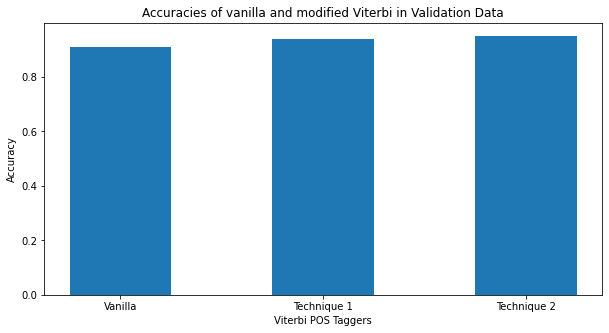

In [40]:
fig = plt.figure(figsize=(10,5))
plt.bar(['Vanilla', 'Technique 1', 'Technique 2'], accuracy_list, width=0.5)
plt.title('Accuracies of vanilla and modified Viterbi in Validation Data')
plt.xlabel('Viterbi POS Taggers')
plt.ylabel('Accuracy')
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [41]:
print(incorrect_tags,'\n')
print(incorrect_tagged_cases_unk,'\n')
print(incorrect_tag_cases_modified_validation)

[[('``', '.'), (('Nasty', 'PRT'), ('Nasty', 'ADJ'))], [('Nasty', 'ADJ'), (('innuendoes', 'PRT'), ('innuendoes', 'NOUN'))], [('John', 'NOUN'), (('Siegal', 'PRT'), ('Siegal', 'NOUN'))], [('to', 'PRT'), (('prosecute', 'PRT'), ('prosecute', 'VERB'))], [('corruption', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('led', 'VERB'), (('*-96', 'PRT'), ('*-96', 'X'))], [('and', 'CONJ'), (('plan', 'NOUN'), ('plan', 'VERB'))], [('.', '.'), (('Discos', 'PRT'), ('Discos', 'NOUN'))], [('are', 'VERB'), (('exempt', 'PRT'), ('exempt', 'ADJ'))], [('permitted', 'VERB'), (('*-60', 'PRT'), ('*-60', 'X'))], [('in', 'ADP'), (('bars', 'PRT'), ('bars', 'NOUN'))], [('will', 'VERB'), (('rule', 'NOUN'), ('rule', 'VERB'))], [('Gulf', 'NOUN'), (('restructure', 'VERB'), ('restructure', 'NOUN'))], [('transaction', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('that', 'DET'), (('*T*-179', 'PRT'), ('*T*-179', 'X'))], [('somewhat', 'ADV'), (('better', 'ADV'), ('better', 'ADJ'))], [('to', 'PRT'), (('arrive', 'PRT'), ('

In [60]:
#get tags from incorrect tagged cases 
def get_taglist(tagged_cases):
    tag_list = []
    for item in tagged_cases:
        #tag_list.append(item[0])
        tag_list.append(item[1])
        #tag_list.append(item[1][1])
    return tag_list


In [61]:
incorrect_tags_vanilla = get_taglist(incorrect_tags)
incorrect_tags_1 = get_taglist(incorrect_tagged_cases_unk)
incorrect_tags_2 = get_taglist(incorrect_tag_cases_modified_validation)

In [72]:
corrected_tags_1 = [x for x in incorrect_tags_vanilla if x not in incorrect_tags_1]
print('List of tags corrected in Validation Data by modified viterbi 1: \n')
print(*corrected_tags_1, sep='\n')
print(len(corrected_tags_1))

List of tags corrected in Validation Data by modified viterbi 1: 

(('Nasty', 'PRT'), ('Nasty', 'ADJ'))
(('innuendoes', 'PRT'), ('innuendoes', 'NOUN'))
(('Siegal', 'PRT'), ('Siegal', 'NOUN'))
(('prosecute', 'PRT'), ('prosecute', 'VERB'))
(('*-96', 'PRT'), ('*-96', 'X'))
(('Discos', 'PRT'), ('Discos', 'NOUN'))
(('exempt', 'PRT'), ('exempt', 'ADJ'))
(('*-60', 'PRT'), ('*-60', 'X'))
(('bars', 'PRT'), ('bars', 'NOUN'))
(('*T*-179', 'PRT'), ('*T*-179', 'X'))
(('arrive', 'PRT'), ('arrive', 'VERB'))
(('firmed', 'PRT'), ('firmed', 'VERB'))
(('faltered', 'PRT'), ('faltered', 'VERB'))
(('Napolitan', 'PRT'), ('Napolitan', 'NOUN'))
14


In [73]:
corrected_tags = [x for x in incorrect_tags_vanilla if x not in incorrect_tags_2]
print('List of tags corrected in Validation Data by modified viterbi 2: \n')
print(*corrected_tags, sep='\n')
print(len(corrected_tags))

List of tags corrected in Validation Data by modified viterbi 2: 

(('Nasty', 'PRT'), ('Nasty', 'ADJ'))
(('innuendoes', 'PRT'), ('innuendoes', 'NOUN'))
(('Siegal', 'PRT'), ('Siegal', 'NOUN'))
(('prosecute', 'PRT'), ('prosecute', 'VERB'))
(('that', 'ADP'), ('that', 'DET'))
(('*-96', 'PRT'), ('*-96', 'X'))
(('Discos', 'PRT'), ('Discos', 'NOUN'))
(('exempt', 'PRT'), ('exempt', 'ADJ'))
(('*-60', 'PRT'), ('*-60', 'X'))
(('bars', 'PRT'), ('bars', 'NOUN'))
(('restructure', 'VERB'), ('restructure', 'NOUN'))
(('that', 'ADP'), ('that', 'DET'))
(('*T*-179', 'PRT'), ('*T*-179', 'X'))
(('better', 'ADV'), ('better', 'ADJ'))
(('arrive', 'PRT'), ('arrive', 'VERB'))
(('firmed', 'PRT'), ('firmed', 'VERB'))
(('faltered', 'PRT'), ('faltered', 'VERB'))
(('enough', 'ADV'), ('enough', 'ADJ'))
(('Napolitan', 'PRT'), ('Napolitan', 'NOUN'))
(('first', 'ADJ'), ('first', 'ADV'))
(('last', 'ADJ'), ('last', 'ADV'))
21


### Validation on test sentences

In [45]:
# Read the test file
test_sentence = open("Test_sentences.txt", "r")
test_text_sentence = test_sentence.read()
test_sentence.close()
print(test_text_sentence)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






In [46]:
#Tokenize sentences to get the word
words = word_tokenize(test_text_sentence)
print(words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [47]:
# Tag words using POS
pos_tagged_test_sentence = nltk.pos_tag(words, tagset='universal')
print("pos_tagged_test_sentence", pos_tagged_test_sentence)

pos_tagged_test_sentence [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'AD

In [48]:
# Validation using vanilla Viterbi
start = time.time()
word_tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print(word_tagged_seq)
print(difference)

[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.'), ('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.'), ('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ("'s", 'PRT'), ('firehose', 'PRT'), ('.', '.'), ('Twitter', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRT'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

In [49]:
# accuracy with vanilla Viterbi
word_check = [i for i, j in zip(word_tagged_seq, pos_tagged_test_sentence) if i == j] 
word_accuracy = len(word_check)/len(word_tagged_seq)
print('Accuracy on test data with vanilla Viterbi: ', word_accuracy)

Accuracy on test data with vanilla Viterbi:  0.7458563535911602


In [50]:
#Incorrect tags with vanilla Viturbi
incorrect_tagged_cases_word = [[pos_tagged_test_sentence[i-1],j] for i, j in enumerate(zip(word_tagged_seq, pos_tagged_test_sentence)) if j[0]!=j[1]]
print(incorrect_tagged_cases_word)
print(len(incorrect_tagged_cases_word))

[[('.', '.'), (('Android', 'PRT'), ('Android', 'NOUN'))], [('mobile', 'ADJ'), (('operating', 'VERB'), ('operating', 'NOUN'))], [('by', 'ADP'), (('Google', 'PRT'), ('Google', 'NOUN'))], [('.', '.'), (('Android', 'PRT'), ('Android', 'NOUN'))], [('best-selling', 'ADJ'), (('OS', 'PRT'), ('OS', 'NOUN'))], [('OS', 'NOUN'), (('worldwide', 'PRT'), ('worldwide', 'NOUN'))], [('on', 'ADP'), (('smartphones', 'PRT'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'PRT'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'PRT'), ('2013', 'NUM'))], [('.', '.'), (('Google', 'PRT'), ('Google', 'NOUN'))], [('and', 'CONJ'), (('Twitter', 'PRT'), ('Twitter', 'NOUN'))], [('in', 'ADP'), (('2015', 'PRT'), ('2015', 'NUM'))], [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('gave', 'VERB'), (('Google', 'PRT'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'PRT'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'PRT'), ('firehose', 'NOUN'))], [('.', '.'), (('Twitter', 'PRT'), ('Twitter',

In [51]:
# Validation to run on Viterbi for unknown words
start = time.time()
word_tagged_seq_unk = Viterbi_1(words)
end = time.time()
difference = end-start
print(word_tagged_seq_unk)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

In [52]:
# accuracy
word_check_unk = [i for i, j in zip(word_tagged_seq_unk, pos_tagged_test_sentence) if i == j] 
word_accuracy_unk = len(word_check_unk)/len(word_tagged_seq_unk)
print('Accuracy with test data using Viterbi 1: ', word_accuracy_unk)

Accuracy with test data using Viterbi 1:  0.861878453038674


In [53]:
# Incorrect Tags with Viterbi 1
incorrect_tagged_cases_word_unk = [[pos_tagged_test_sentence[i-1],j] for i, j in enumerate(zip(word_tagged_seq_unk, pos_tagged_test_sentence)) if j[0]!=j[1]]
print(incorrect_tagged_cases_word_unk)
print(len(incorrect_tagged_cases_word_unk))

[[('by', 'ADP'), (('Google', 'DET'), ('Google', 'NOUN'))], [('on', 'ADP'), (('smartphones', 'DET'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'DET'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'DET'), ('2013', 'NUM'))], [('in', 'ADP'), (('2015', 'DET'), ('2015', 'NUM'))], [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('gave', 'VERB'), (('Google', 'X'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'VERB'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'VERB'), ('firehose', 'NOUN'))], [('an', 'DET'), (('online', 'NOUN'), ('online', 'ADJ'))], [('with', 'ADP'), (('messages', 'DET'), ('messages', 'NOUN'))], [('messages', 'NOUN'), (('known', 'ADJ'), ('known', 'VERB'))], [('as', 'ADP'), (('tweets', 'DET'), ('tweets', 'NOUN'))], [('a', 'DET'), (('domineering', 'NOUN'), ('domineering', 'ADJ'))], [('The', 'DET'), (('2018', 'NOUN'), ('2018', 'NUM'))], [('the', 'DET'), (('21st', 'NOUN'), ('21st', 'NUM'))], [('tournament', 'NOUN'), (('contested', 'NOUN'), (

In [54]:

#The validation accuracy for the modified code using regex
tagged_seq_validation_regex = word_tagged_seq_unk
tagged_seq_validation_result_regex = Viterbi_2(incorrect_tagged_cases_word_unk, tagged_seq_validation_regex)

tagged_seq_validation_result_regex.sort()
pos_tagged_test_sentence.sort()
check_validation_regex = [i for i, j in zip(tagged_seq_validation_result_regex, pos_tagged_test_sentence) if i == j] 
accuracy_validation_regex = len(check_validation_regex)/len(tagged_seq_validation_result_regex)
print(accuracy_validation_regex)
print('Accuracy with test data using Viterbi 2: ', accuracy_validation_regex)

0.9281767955801105
Accuracy with test data using Viterbi 2:  0.9281767955801105


In [55]:
# Incorrect tags with Viterbi 2
incorrect_tagged_cases_word_regex = [[pos_tagged_test_sentence[i-1],j] for i, j in enumerate(zip(tagged_seq_validation_result_regex, pos_tagged_test_sentence)) if j[0]!=j[1]]
print(incorrect_tagged_cases_word_regex)
print(len(incorrect_tagged_cases_word_regex))

[[('.', '.'), (('11th', 'NOUN'), ('11th', 'NUM'))], [('2018', 'NUM'), (('21st', 'NOUN'), ('21st', 'NUM'))], [('Satellite', 'NOUN'), (('Show', 'NOUN'), ('Show', 'VERB'))], [('Show', 'VERB'), (('Show', 'NOUN'), ('Show', 'VERB'))], [('a', 'DET'), (('about', 'NOUN'), ('about', 'ADV'))], [('developed', 'VERB'), (('domineering', 'VERB'), ('domineering', 'ADJ'))], [('every', 'DET'), (('experience', 'NOUN'), ('experience', 'VERB'))], [('it', 'PRON'), (('known', 'NOUN'), ('known', 'VERB'))], [('leaving', 'VERB'), (('like', 'NOUN'), ('like', 'VERB'))], [('media', 'NOUN'), (('messages', 'VERB'), ('messages', 'NOUN'))], [('once', 'ADV'), (('online', 'NOUN'), ('online', 'ADJ'))], [('since', 'ADP'), (('smartphones', 'VERB'), ('smartphones', 'NOUN'))], [('that', 'ADP'), (('that', 'NOUN'), ('that', 'DET'))]]
13


##### Comparing accuracies of vanilla and modified viterbi on test sentences

In [59]:
print('Accuracy on test data with vanilla Viterbi: ', word_accuracy)
print('Accuracy with test data using Viterbi 1: ', word_accuracy_unk)
print('Accuracy with test data using Viterbi 2: ', accuracy_validation_regex)

Accuracy on test data with vanilla Viterbi:  0.7458563535911602
Accuracy with test data using Viterbi 1:  0.861878453038674
Accuracy with test data using Viterbi 2:  0.9281767955801105


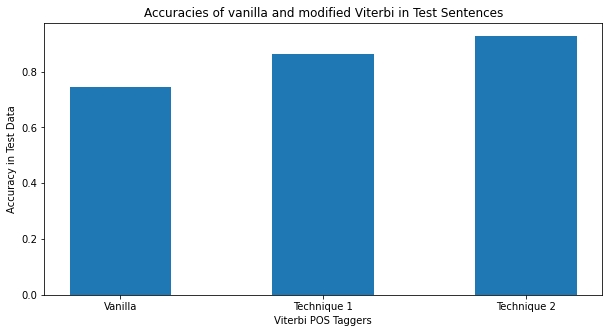

In [56]:
fig = plt.figure(figsize=(10,5))
plt.bar(['Vanilla', 'Technique 1', 'Technique 2'], [word_accuracy, word_accuracy_unk, accuracy_validation_regex], width=0.5)

plt.title("Accuracies of vanilla and modified Viterbi in Test Sentences")
plt.xlabel('Viterbi POS Taggers')
plt.ylabel('Accuracy in Test Data')
plt.show()

#### Cases in test sentences which were incorrectly tagged by original POS tagger and got corrected by modifications

In [63]:
test_incorrect_tags_vanilla = get_taglist(incorrect_tagged_cases_word)
test_incorrect_tags_1 = get_taglist(incorrect_tagged_cases_word_unk)
test_incorrect_tags_2 = get_taglist(incorrect_tagged_cases_word_regex)

In [70]:
test_corrected_tags_1 = [x for x in test_incorrect_tags_vanilla if x not in test_incorrect_tags_1]
print('List of tags corrected in Test Data by modified viterbi 1: \n')
print(*test_corrected_tags_1, sep='\n')
print(len(test_corrected_tags_1))

List of tags corrected in Test Data by modified viterbi 1: 

(('Android', 'PRT'), ('Android', 'NOUN'))
(('operating', 'VERB'), ('operating', 'NOUN'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Android', 'PRT'), ('Android', 'NOUN'))
(('OS', 'PRT'), ('OS', 'NOUN'))
(('worldwide', 'PRT'), ('worldwide', 'NOUN'))
(('smartphones', 'PRT'), ('smartphones', 'NOUN'))
(('2011', 'PRT'), ('2011', 'NUM'))
(('2013', 'PRT'), ('2013', 'NUM'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('2015', 'PRT'), ('2015', 'NUM'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('firehose', 'PRT'), ('firehose', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('online', 'PRT'), ('online', 'ADJ'))
(('post', 'VERB'), ('post', 'NOUN'))
(('interact', 'PRT'), ('interact', 'NOUN'))
(('messages', 'PRT'), ('messages', 'NOUN'))
(('tweets', 'PRT'), ('tweets', 'NOUN'))
(('domineering', 'PRT'), ('domineering', 'ADJ'))
(('personality', 'PRT'), ('perso

In [71]:
test_corrected_tags_2 = [x for x in test_incorrect_tags_vanilla if x not in test_incorrect_tags_2]
print('List of tags corrected in Test Data by modified viterbi 2: \n')
print(*test_corrected_tags_2, sep='\n')
print(len(test_corrected_tags_2))

List of tags corrected in Test Data by modified viterbi 2: 

(('Android', 'PRT'), ('Android', 'NOUN'))
(('operating', 'VERB'), ('operating', 'NOUN'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Android', 'PRT'), ('Android', 'NOUN'))
(('OS', 'PRT'), ('OS', 'NOUN'))
(('worldwide', 'PRT'), ('worldwide', 'NOUN'))
(('smartphones', 'PRT'), ('smartphones', 'NOUN'))
(('2011', 'PRT'), ('2011', 'NUM'))
(('2013', 'PRT'), ('2013', 'NUM'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('2015', 'PRT'), ('2015', 'NUM'))
(('that', 'ADP'), ('that', 'DET'))
(('Google', 'PRT'), ('Google', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('firehose', 'PRT'), ('firehose', 'NOUN'))
(('Twitter', 'PRT'), ('Twitter', 'NOUN'))
(('online', 'PRT'), ('online', 'ADJ'))
(('post', 'VERB'), ('post', 'NOUN'))
(('interact', 'PRT'), ('interact', 'NOUN'))
(('messages', 'PRT'), ('messages', 'NOUN'))
(('tweets', 'PRT'), ('tweets', 'NOUN'))
(('domineering', 'PRT'), ('domineering', 'ADJ'